In [1]:
import pandas as pd
from sklearn.preprocessing import PowerTransformer, StandardScaler
from torch import nn
import numpy as np
from itertools import islice
import torch
import numpy
from sklearn.model_selection import train_test_split
import statistics as stats
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.metrics import mean_squared_error
from functions import MyLSTM, black_process, white_process

# Importing the data

In [2]:
def to_list(str):
    '''
    :param str: string representing a list of centipawn losses
    :return: list of integer centipawn losses
    '''
    string = str.replace('[','').replace(']','')
    ls = string.split(',')
    if '' in ls:
        print(f"WHAT THE FUCK : {str}")
    list = [float(i) for i in ls]
    return list

In [3]:
df = pd.read_csv('lichess_db_standard_rated_2023-08_1_1000000.csv', dtype  ={'Eval':'string'})

In [4]:
# filtering out None or empty evaluations
df = df[ df['Eval'].apply(lambda x: isinstance(x, str))]
df = df[~df['Eval'].str.contains('None')]
df = df[df['Eval']!='']
df = df[df['Eval'] != '']
df = df[df['Eval'] != '[]']

In [5]:
df.value_counts('TimeControl')

TimeControl
600+0       15404
180+0       14146
60+0        11808
300+0       10071
180+2        9539
            ...  
1080+9          1
720+2           1
7200+120        1
7200+45         1
420+4           1
Name: count, Length: 295, dtype: int64

In [6]:
# picking a time control - I'm looking at 3 minute games
df = df[df["Clock"] != '[]']
df = df[~df["Clock"].str.contains(',,')]

In [7]:
# defining a function to return initial time and increment
def get_init_time(string):
    t = string.split('+')
    return int(t[0])

def get_inc(string):
    t = string.split('+')
    return int(t[1])

In [8]:
# Filtering out * values
df = df[df['WhiteELO'] != '*']
df = df[df['BlackELO'] != '*']
df[['WhiteELO', 'BlackELO']] = df[['WhiteELO', 'BlackELO']] .astype(int)

# converting the evaluations and clock times to lists
df['Eval'] = df['Eval'].apply( to_list)
df['Clock'] = df['Clock'].apply(to_list)

df['Increment'] = df["TimeControl"].apply(get_inc)
df['Init_time'] = df["TimeControl"].apply(get_init_time)

# processing the evaluations and clock times into feature sequences
df['WhiteEval'] =df.apply(lambda x : white_process(x.Eval, x.Clock, x.Init_time, x.Init_time, x.Increment), axis =1 )
df['BlackEval'] = df.apply(lambda x : black_process(x.Eval, x.Clock,x.Init_time,x.Init_time,x.Increment), axis =1 )

In [9]:
df['Clock'].head()

0    [300.0, 300.0, 299.0, 299.0, 298.0, 297.0, 297...
1    [300.0, 300.0, 295.0, 301.0, 293.0, 303.0, 292...
2    [300.0, 300.0, 299.0, 289.0, 276.0, 286.0, 273...
3    [180.0, 180.0, 181.0, 182.0, 183.0, 183.0, 184...
4    [60.0, 60.0, 60.0, 59.0, 59.0, 59.0, 59.0, 58....
Name: Clock, dtype: object

In [10]:
df.Eval

0        [0.0, 27.0, 29.0, 30.0, 16.0, 94.0, -74.0, 64....
1        [0.0, 27.0, 29.0, 30.0, 16.0, 27.0, 15.0, 21.0...
2        [0.0, 98.0, 80.0, 159.0, 23.0, 47.0, 19.0, 942...
3        [0.0, 90.0, 34.0, 30.0, 50.0, 126.0, 98.0, 117...
4        [0.0, 27.0, 13.0, 51.0, 2.0, 35.0, 3.0, 66.0, ...
                               ...                        
86989    [36.0, 32.0, 0.0, 0.0, 14.0, 39.0, 25.0, 45.0,...
86990    [36.0, 35.0, 29.0, 32.0, 21.0, 20.0, 25.0, 152...
86991    [36.0, 35.0, 29.0, 32.0, 21.0, 76.0, 56.0, 98....
86992    [36.0, 32.0, 0.0, 15.0, 0.0, 11.0, 0.0, 0.0, 0...
86993    [0.0, 27.0, 0.0, 6.0, 9.0, 58.0, 39.0, 52.0, 2...
Name: Eval, Length: 86764, dtype: object

In [11]:
df['WhiteEval'].head()

0    [[99.9999, 0.0, 300.0, 0.0], [100.827984665876...
1    [[99.9999, 0.0, 300.0, 3.0], [100.827984665876...
2    [[99.9999, 0.0, 300.0, 3.0], [93.0026466903715...
3    [[99.9999, 0.0, 180.0, 2.0], [79.5140928593466...
4    [[99.9999, 0.0, 60.0, 0.0], [94.37821348021421...
Name: WhiteEval, dtype: object

In [12]:
df['BlackEval'].head()

0    [[111.78026008039805, 0.0, 300.0, 0.0], [100.4...
1    [[111.78026008039805, 0.0, 300.0, 3.0], [100.4...
2    [[148.99095016059312, 0.0, 300.0, 3.0], [136.2...
3    [[144.32847935142507, 0.0, 180.0, 2.0], [98.36...
4    [[111.78026008039805, 0.0, 60.0, 0.0], [116.90...
Name: BlackEval, dtype: object

In [13]:
#copying black's evaluations to the same column as white's, so we examine each game from both perspectives
# NOTE: I'm filtering out some elos between 1200 and  2200 to try to get a larger range of predictions 
df_flipped = df.copy()
df_flipped['WhiteEval'] = df_flipped['BlackEval']
df_flipped['WhiteELO'] = df_flipped['BlackELO'].astype(float)
df_flipped['White'] = df_flipped['Black']
df_flipped = df_flipped[ (df_flipped['WhiteELO'] <1200) | (df_flipped['WhiteELO'] >2200)]
df = pd.concat([df, df_flipped])

In [14]:
# Another idea is to predict the elo difference?

In [15]:
print(f"Evaluted games: {len(df['Eval'])}")

Evaluted games: 108463


# Regularizing Data

In [16]:
white_x = numpy.array(df['WhiteEval'])
white_length = numpy.array(df['WhiteEval'].apply(len))

black_x = numpy.array(df['WhiteEval'])
black_length = numpy.array(df['WhiteEval'].apply(len))

In [17]:
white_x

array([array([[ 99.9999    ,   0.        , 300.        ,   0.        ],
              [100.82798467,   1.        , 300.        ,   0.        ],
              [ 94.38060112,   1.        , 300.        ,   0.        ],
              [ 49.74088299,   1.        , 300.        ,   0.        ],
              [ 98.78295685,   5.        , 300.        ,   0.        ],
              [ 91.80605714,   3.        , 300.        ,   0.        ],
              [ 71.30705561,   3.        , 300.        ,   0.        ],
              [ 94.00560113,   1.        , 300.        ,   0.        ],
              [ 95.58790565,   2.        , 300.        ,   0.        ],
              [100.71316542,   3.        , 300.        ,   0.        ],
              [ 27.3340202 ,   1.        , 300.        ,   0.        ],
              [ 89.1243955 ,   1.        , 300.        ,   0.        ],
              [ 84.75713145,   5.        , 300.        ,   0.        ],
              [105.19618335,   1.        , 300.        ,   0.   

In [18]:
# creating and fitting a power transformer for black and white
wpt = StandardScaler()

white_y = numpy.concatenate(white_x) # concatenating so that the data has shape (samples,features)


In [19]:
white_y

array([[ 99.9999    ,   0.        , 300.        ,   0.        ],
       [100.82798467,   1.        , 300.        ,   0.        ],
       [ 94.38060112,   1.        , 300.        ,   0.        ],
       ...,
       [ 89.32473765,   1.        , 180.        ,   2.        ],
       [ 99.95994796,   1.        , 180.        ,   2.        ],
       [ 99.96008752,   2.        , 180.        ,   2.        ]])

In [20]:

wpt.fit(white_y)
white_transformed = wpt.transform(white_y)


In [21]:
bpt = PowerTransformer()
black_y = numpy.concatenate(black_x)
bpt.fit(black_y)
black_transformed = bpt.transform(black_y)

In [22]:
from joblib import dump
dump(wpt, 'w_eval_scaler.bin', compress=True)
dump(bpt, 'b_eval_scaler.bin', compress=True)

['b_eval_scaler.bin']

<Axes: >

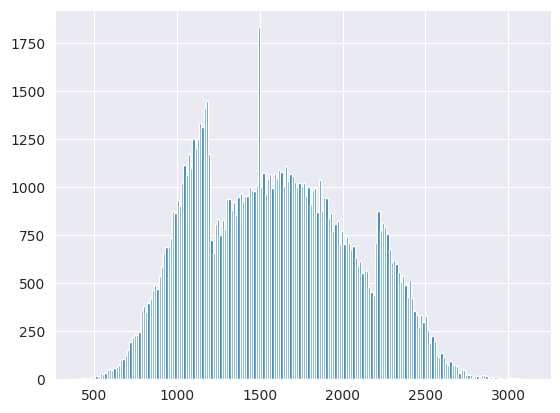

In [23]:
df['WhiteELO'].hist(bins = 200)

In [24]:
white_elo_arr = numpy.array(df['WhiteELO'])

In [25]:
#welopt = PowerTransformer(method = 'box-cox')
welopt = StandardScaler()
white_elo_arr = np.reshape(white_elo_arr, (len(white_elo_arr),1))
welopt.fit(white_elo_arr)
white_elo_transformed = welopt.transform(white_elo_arr)

(array([   79.,   544.,  2247.,  5066.,  9386., 12203.,  8340.,  9595.,
        11188., 10407.,  9600.,  7969.,  6096.,  6904.,  5034.,  2557.,
          875.,   244.,    99.,    30.]),
 array([-2.51696462, -2.22941618, -1.94186774, -1.6543193 , -1.36677086,
        -1.07922242, -0.79167398, -0.50412554, -0.2165771 ,  0.07097134,
         0.35851978,  0.64606822,  0.93361666,  1.2211651 ,  1.50871354,
         1.79626198,  2.08381042,  2.37135886,  2.6589073 ,  2.94645574,
         3.23400419]),
 <BarContainer object of 20 artists>)

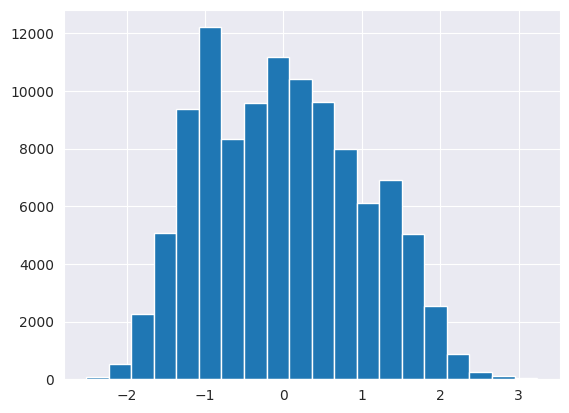

In [26]:
plt.hist(white_elo_transformed, bins =20)

In [27]:
white_transformed_array = [numpy.array(list(islice(iter(white_transformed), elem)))
        for elem in white_length]

black_transformed_array = [numpy.array(list(islice(iter(black_transformed), elem)))
        for elem in black_length]

# Splitting data into a training and test set

In [28]:
white_transformed_array[100]

array([[ 0.00127079, -0.42884681, -0.12454553, -0.37574767],
       [ 0.00820596, -0.34651642, -0.12454553, -0.37574767],
       [-0.04579055, -0.34651642, -0.12454553, -0.37574767],
       [-0.41964588, -0.34651642, -0.12454553, -0.37574767],
       [-0.00892104, -0.01719489, -0.12454553, -0.37574767],
       [-0.06735222, -0.18185566, -0.12454553, -0.37574767],
       [-0.2390303 , -0.18185566, -0.12454553, -0.37574767],
       [-0.04893115, -0.34651642, -0.12454553, -0.37574767],
       [-0.03567943, -0.26418604, -0.12454553, -0.37574767],
       [ 0.00724435, -0.18185566, -0.12454553, -0.37574767],
       [-0.6073022 , -0.34651642, -0.12454553, -0.37574767]])

In [29]:
# converting evaluations and length to tensors
white_evals = [torch.tensor(i, dtype = torch.float32) for i in white_transformed_array]
white_lengths = [len(tensor) for tensor in white_evals]

black_evals = [torch.tensor(i, dtype = torch.float32) for i in black_transformed_array]
black_lengths = [len(tensor) for tensor in black_evals]


In [30]:
def avg_cpl(white_processed):
    '''
    return the average centipawn loss from an evaluated game
    :param white_processed: list of lists of the form [evaluation, centipawn loss]
    :return: average centipawn loss (float)
    '''
    cpls = []
    for i in white_processed:
        cpls.append(i[1])
    if len(cpls) == 0:
        return float('NaN')
    else:
        return stats.mean(cpls)

In [31]:
df['White_avg_cpl'] = df['WhiteEval'].copy().apply( avg_cpl )

In [32]:
# Converting White and Black's ELOs to tensors
white_elo = [torch.tensor(i, dtype = torch.float32) for i in white_elo_transformed]

black_elo = numpy.array(df['BlackELO'])
black_elo = [torch.tensor(i, dtype = torch.float32) for i in black_elo]

average_cpl = np.array(df['White_avg_cpl'])

# splitting into train and test
white_eval_train, white_eval_test, black_eval_train, black_eval_test, black_train, black_test, white_train, white_test, average_cpl_train, average_cpl_test = train_test_split(white_evals, black_evals, black_elo, white_elo, average_cpl, test_size=0.2,random_state=0, shuffle = True)

In [33]:
# zipping together the features and targets
train_data_zip = list(zip(white_eval_train, white_train))
test_data_zip = list(zip(white_eval_test, white_test))

In [34]:
# black_elo = torch.stack(black_elo)
# white_elo = torch.stack(white_elo)

## Baseline model

In [35]:
average_cpl_train = np.reshape(average_cpl_train, (len(average_cpl_train),1))
average_cpl_test = np.reshape(average_cpl_test, (len(average_cpl_test),1))

In [36]:
white_train_elo = np.array([x.item() for x in white_train])
white_train_elo = np.reshape(white_train_elo, (len(white_train_elo),1 ))
white_train_elo_transformed = welopt.inverse_transform(white_train_elo)

white_test_elo = np.array([x.item() for x in white_test])
white_test_elo = np.reshape(white_test_elo, (len(white_test_elo),1 ))
white_test_elo_transformed = welopt.inverse_transform(white_test_elo)

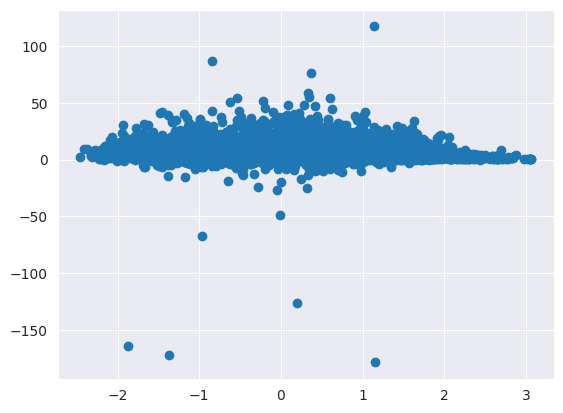

In [37]:
plt.scatter(white_test_elo,average_cpl_test)

In [38]:
# make a simple linear regression model.
regression = LinearRegression()
regression.fit(average_cpl_train,white_train_elo_transformed)
regression.score(average_cpl_test,white_test_elo)
y_pred = regression.predict(average_cpl_test)

In [39]:
mse_lin = mean_squared_error(white_test_elo_transformed, y_pred)

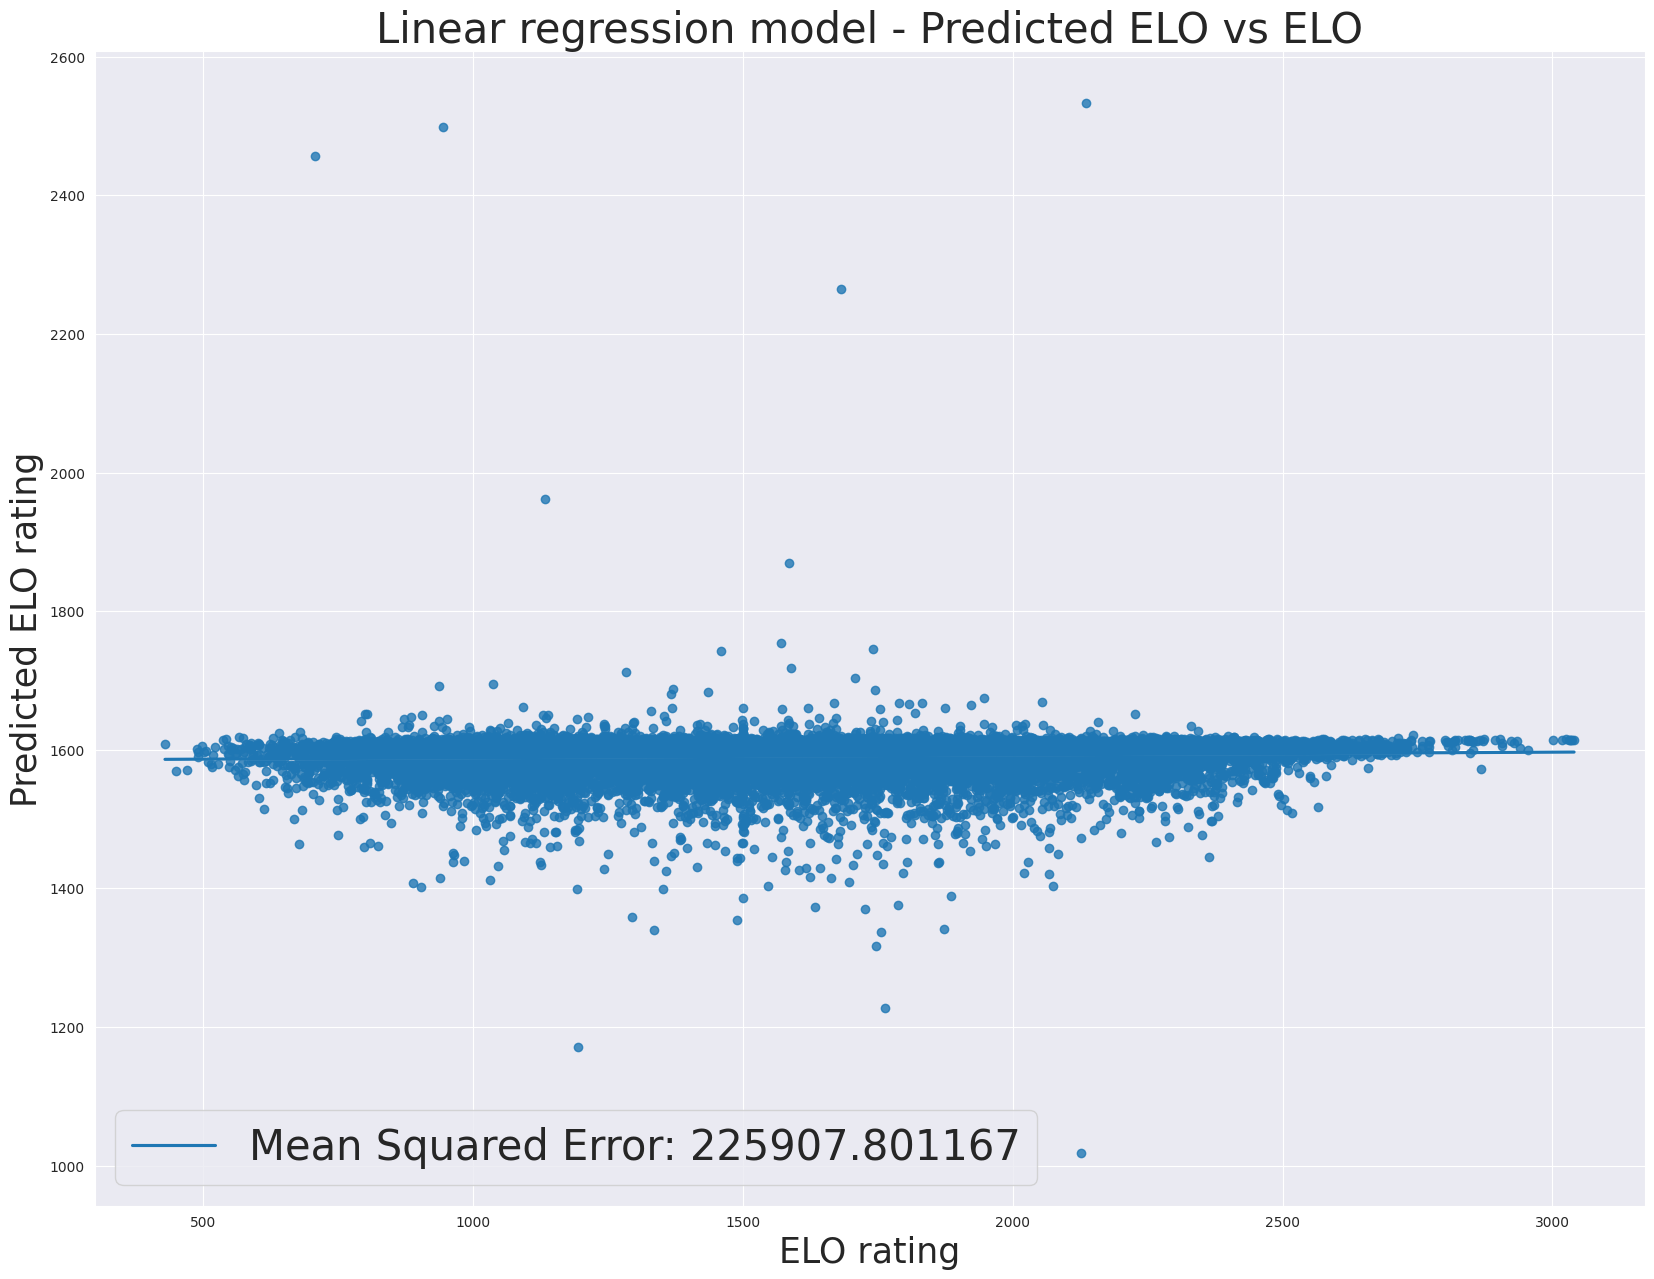

In [40]:
plt.figure(figsize = (20,15))
plt.title('Linear regression model - Predicted ELO vs ELO', fontsize = 30)
sns.regplot(x = white_test_elo_transformed, y = y_pred, line_kws = {'label':f'Mean Squared Error: {mse_lin:4f}'})
plt.xlabel('ELO rating', fontsize = 25)
plt.ylabel('Predicted ELO rating', fontsize = 25)
plt.legend(prop={'size': 30})

# Creating the Neural Network

In [41]:
class MyCollator(object):
    '''
    Yields a batch from a list of Items
    Args:
    test : Set True when using with test data loader. Defaults to False
    percentile : Trim sequences by this percentile
    '''

    def __call__(self, batch):
        white_data = [item[0] for item in batch]
        #print(f"FIRST WD COLL: {white_data[7]}")
        target = [item[1] for item in batch]
        #print(f"TARGET: {target[7]}")
        white_lens = [i.shape[0] for i in white_data]
        white_data = torch.nn.utils.rnn.pad_sequence(white_data, batch_first=True,padding_value = 0)
        #print("WHite data 2 shape",(white_data).size())
        white_evals_packed = torch.nn.utils.rnn.pack_padded_sequence(white_data,batch_first = True, lengths=white_lens,enforce_sorted=False)
        target = torch.tensor(target,dtype=torch.float32)
        return [white_evals_packed, target]

In [60]:
# defining parameters for the neural net
input_size = 4
hidden_size = 16
no_layers = 2
batch_size = 64

In [61]:
model = MyLSTM(input_size, hidden_size, no_layers)
collate = MyCollator()
print(model.parameters)

<bound method Module.parameters of MyLSTM(
  (lstm): LSTM(4, 16, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (final): LeakyReLU(negative_slope=0.01)
)>


# Training the model

In [62]:
writer = SummaryWriter('runs/h45l4-2')

In [63]:
data_loader = torch.utils.data.DataLoader(train_data_zip, batch_size=batch_size, shuffle=True ,collate_fn=collate)

In [64]:
learning_rate = .00001

In [65]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [66]:
criterion = nn.MSELoss()
#criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

Average loss : 1.013863772241767
Epoch 1 step 1357 - Learning Rate : 1e-05- Avg Loss: 0.996533 - Change in loss: 9.965326124939594


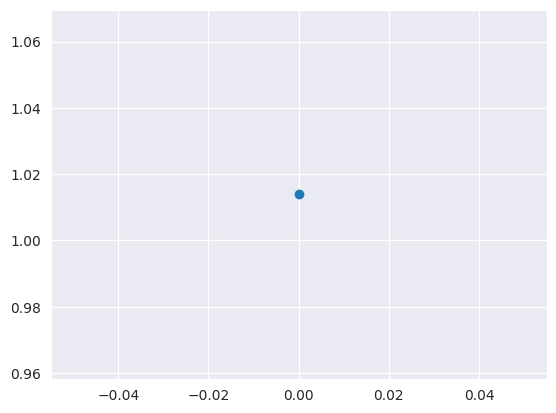

Average loss : 1.0113738189756343
Epoch 2 step 1357 - Learning Rate : 1e-05- Avg Loss: 0.995725 - Change in loss: 0.9991893694571731


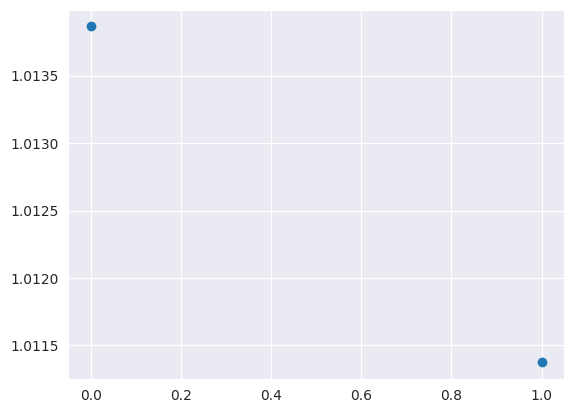

Average loss : 1.007206662390436
Epoch 3 step 1357 - Learning Rate : 1e-05- Avg Loss: 0.992509 - Change in loss: 0.996770260950043


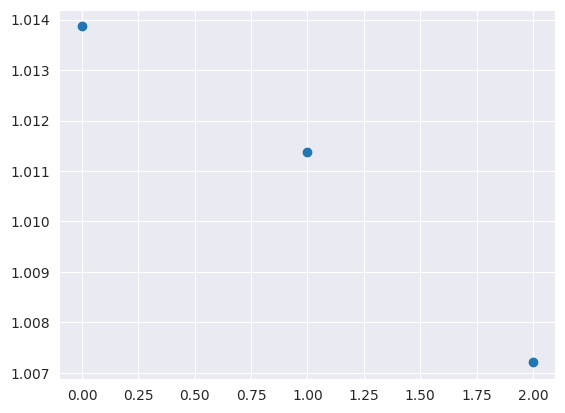

Average loss : 1.0013010521202312
Epoch 4 step 1357 - Learning Rate : 1e-05- Avg Loss: 0.988251 - Change in loss: 0.9957094986894798


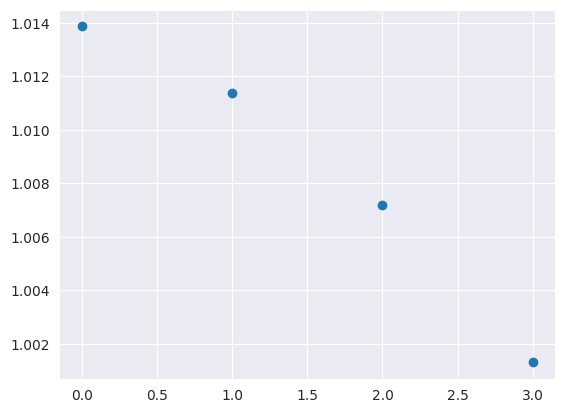

Average loss : 0.9937548922226492
Epoch 5 step 1357 - Learning Rate : 1e-05- Avg Loss: 0.982096 - Change in loss: 0.9937718482103491


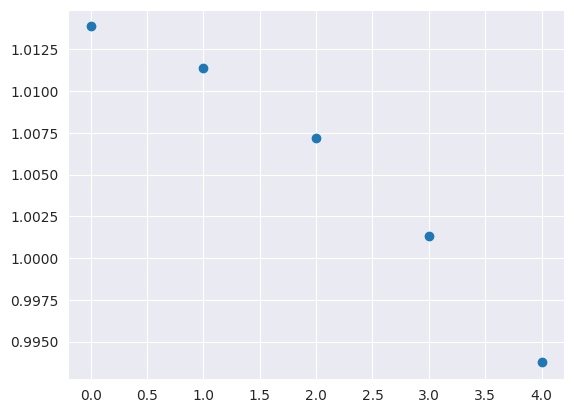

Average loss : 0.9867560923275343
Epoch 6 step 1357 - Learning Rate : 1e-05- Avg Loss: 0.975169 - Change in loss: 0.9929477052704865


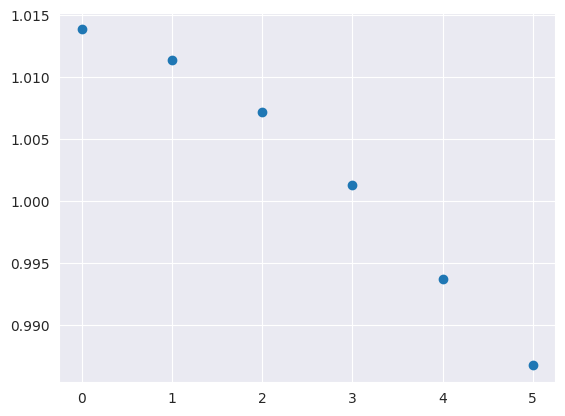

Average loss : 0.9837801709639288
Epoch 7 step 1357 - Learning Rate : 1e-05- Avg Loss: 0.970184 - Change in loss: 0.994887748540742


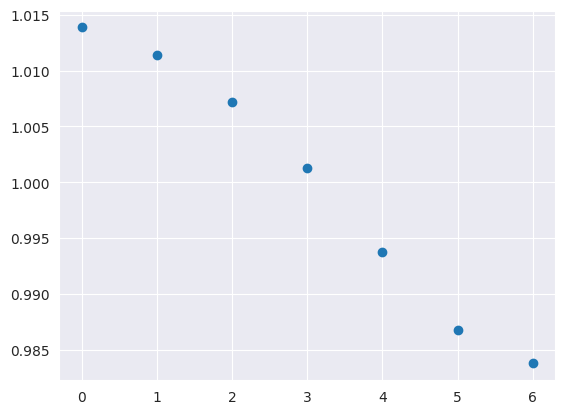

Average loss : 0.9827937747524903
Epoch 8 step 1357 - Learning Rate : 1e-05- Avg Loss: 0.967994 - Change in loss: 0.9977421395368865


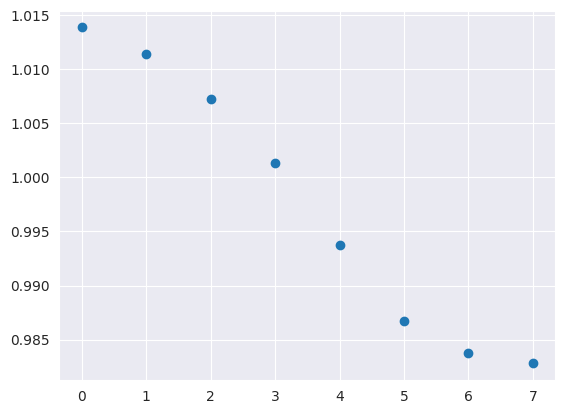

Average loss : 0.9821793067771777
Epoch 9 step 1357 - Learning Rate : 1e-05- Avg Loss: 0.966921 - Change in loss: 0.9988915056875789


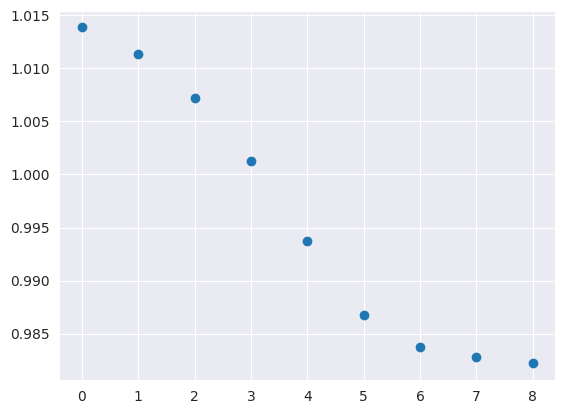

Average loss : 0.9818841115211667
Epoch 10 step 1357 - Learning Rate : 1e-05- Avg Loss: 0.966432 - Change in loss: 0.9994945199864194


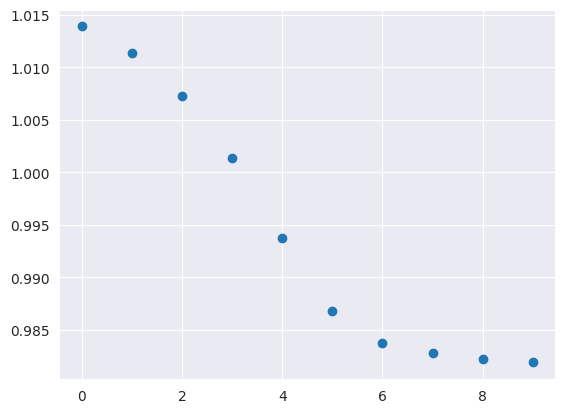

Average loss : 0.9817478257646252
Epoch 11 step 1357 - Learning Rate : 1e-05- Avg Loss: 0.966085 - Change in loss: 0.9996413432474319


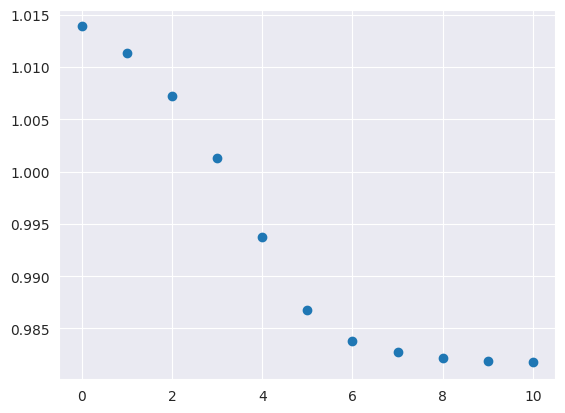

Average loss : 0.9816660265655293
Epoch 12 step 1357 - Learning Rate : 1e-05- Avg Loss: 0.965925 - Change in loss: 0.999834213560915


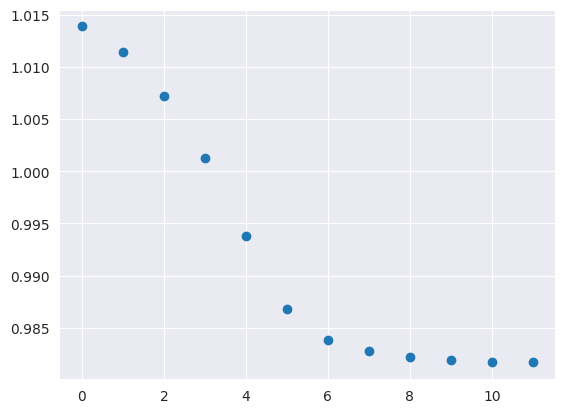

Average loss : 0.981880671682611
Epoch 13 step 1357 - Learning Rate : 1e-05- Avg Loss: 0.965693 - Change in loss: 0.999759449728833


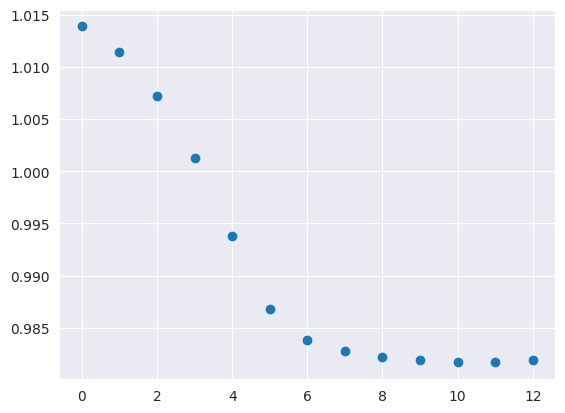

Average loss : 0.9815822257756484
Epoch 14 step 1357 - Learning Rate : 1e-05- Avg Loss: 0.965591 - Change in loss: 0.9998942170427608


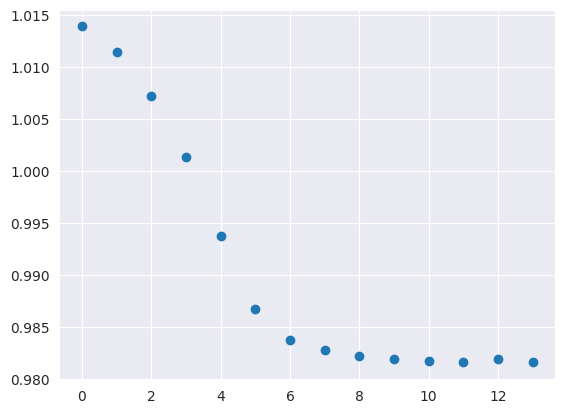

Average loss : 0.9814633582897243
Epoch 15 step 1357 - Learning Rate : 1e-05- Avg Loss: 0.965438 - Change in loss: 0.9998422496846565


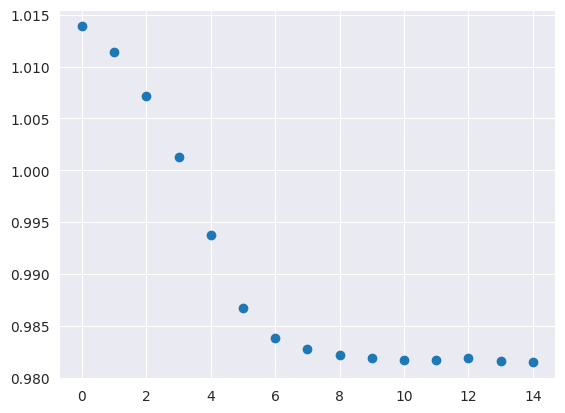

KeyboardInterrupt: 

In [67]:
avg_losses = []
epochs = []
avg_loss = 0.1


test_data_loader = torch.utils.data.DataLoader(test_data_zip, batch_size=batch_size, shuffle=False ,collate_fn=collate)
for epoch in range(1000):
    data_loader = torch.utils.data.DataLoader(train_data_zip, batch_size=batch_size, shuffle=True,collate_fn=collate)
    losses = []
    model.train()
    i = 0
    for white_evals, elo in data_loader:
        white_evals = white_evals.to(device)
        elo = elo.to(device)
        outputs = model(white_evals)
        loss = criterion(outputs,elo)

        # optimizing
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        i+=1
        
    # evaluating on the test data
    model.eval()
    tlosses = []
    for evals, elo in test_data_loader:
        evals = evals.to(device)
        elo = elo.to(device)
        output = model(evals)
        loss = criterion(output,elo)
        tlosses.append(loss.item())
    print(f'Average loss : {stats.mean(tlosses)}')
    
    
    change = stats.mean(losses)/avg_loss
    avg_loss = stats.mean(losses)

    # adding histograms to the summary writer
    for name, param in model.named_parameters():
        writer.add_histogram(name, np.array(param.detach().tolist()), epoch)

    # adding loss
    writer.add_scalar('Average loss',stats.mean(tlosses), epoch)
    avg_losses.append(stats.mean(tlosses))
    epochs.append(epoch)
    print(f'Epoch {epoch+1} step {i+1} - Learning Rate : {learning_rate}- Avg Loss: {avg_loss:3f} - Change in loss: {change}')
    torch.save(model.state_dict(), f'networks/main_model_epoch_{epoch+1}.pt')
    plt.scatter(epochs, avg_losses)
    plt.show()
writer.close()

## Evaluating the model

In [50]:
model =model.eval()

In [51]:
model.to(device)

MyLSTM(
  (lstm): LSTM(4, 16, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (final): LeakyReLU(negative_slope=0.01)
)

In [52]:
test_data_loader1 = torch.utils.data.DataLoader(test_data_zip, batch_size=1, shuffle=False ,collate_fn=collate)

In [53]:
# getting a list of outputs for the test data
losses = []
outputs = []
elos = []
for evals, elo in test_data_loader1:
    evals = evals.to(device)
    elo = elo.to(device)
    output = model(evals)
    outputs.append(output.item())
    elos.append(elo.item())
    loss = criterion(output,elo)
    losses.append(loss.item())
print(f'Average loss : {stats.mean(losses)}')

Average loss : 0.9812054841434501


In [54]:
# preparing data to be inverse transformed
elos = np.array(elos)
elos = np.reshape(elos, (len(elos),1))

outputs = np.array(outputs)
outputs = np.reshape(outputs, (len(outputs),1))

In [55]:
# getting elos from the normalized values
elos = welopt.inverse_transform(elos)
outputs = welopt.inverse_transform(outputs)

In [56]:
mse_model = mean_squared_error(elos,outputs)

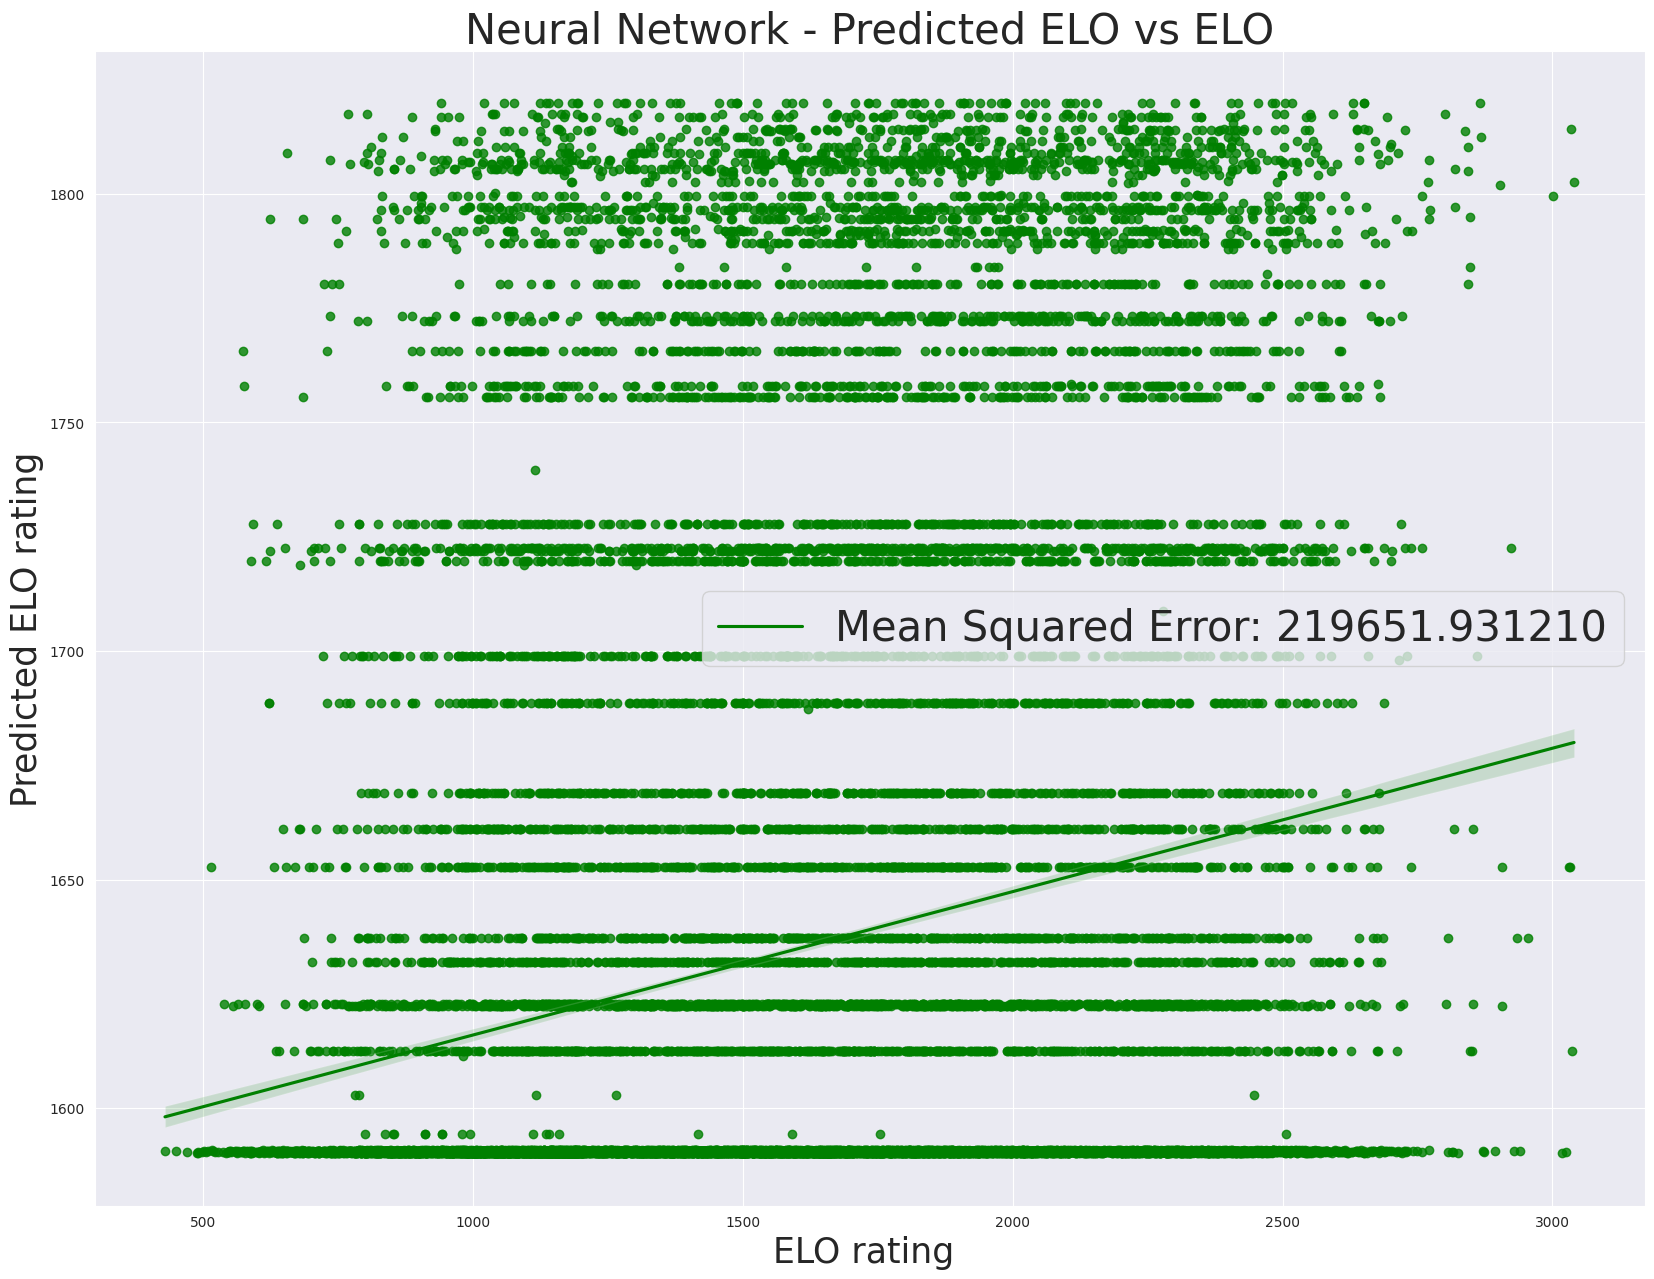

In [57]:
plt.figure(figsize = (20,15))
plt.title('Neural Network - Predicted ELO vs ELO', fontsize = 30)
sns.regplot(x = elos, y = outputs, color ='green', line_kws = {'label':f'Mean Squared Error: {mse_model:4f}'})
plt.xlabel('ELO rating ', fontsize = 25)
plt.ylabel('Predicted ELO rating', fontsize = 25)
plt.legend(prop={'size': 30})
#plt.savefig('images/NN_model_acc1.png')

In [58]:
torch.save(model.state_dict(), 'main_model.pt')

In [ ]:
model.load_state_dict(torch.load('main_model.pt'))

In [ ]:
sns.regplot(elos,outputs)